In [2]:
%load_ext autoreload
%autoreload 1

In [4]:
import numpy as np
import pytorch_lightning as pl
import torch
from pytorch_lightning.loggers import WandbLogger

from opf.dataset import CaseDataModule
from opf.modules import OPFLogBarrier, GNN
from opf.utils import graph_info
%aimport opf
%aimport opf.modules

In [5]:
# constants
data_dir = "../data"

# parameters that should be saved for logging
param = dict(
    case_name="case30",
    A_scaling=300,
    A_threshold=0.01,
    model="selection",
    batch_size=512,
    num_workers=16,
    pin_memory=True
)
dm = CaseDataModule(
    param["case_name"],
    data_dir=data_dir,
    batch_size=param["batch_size"],
    ratio_train=0.8
)

Non-zero edges: 82
Connected components: 1


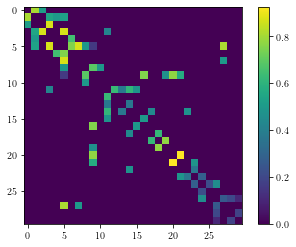

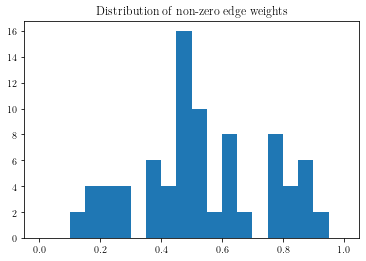

Non-zero edges: 82
Connected components: 1


In [6]:
# Choose scaling factor so that the mean weight is 0.5
param["A_scaling"] = 2 * np.exp(-1) / np.mean(dm.net_wrapper.impedence_matrix().data)
adjacency = dm.adjacency(param["A_scaling"], param["A_threshold"])
graph_info(adjacency, plot=True)
# Normalize GSO by dividing by larget eigenvalue
gso = adjacency / np.max(np.real(np.linalg.eigh(adjacency)[0]))

adjacency = dm.adjacency(param["A_scaling"], param["A_threshold"])
graph_info(adjacency)
# Normalize GSO by dividing by larget eigenvalue
gso = adjacency / np.max(np.real(np.linalg.eigh(adjacency)[0]))


In [10]:
gnn = GNN(
    gso,
    [8, 64, 64, 4],
    [4, 4, 4],
    [4 * dm.net_wrapper.n_buses]
).float()

barrier = OPFLogBarrier(
    dm.net_wrapper,
    gnn,
    t=20,
    s=10,
    cost_weight=1.0,
    type="relaxed_log",
    lr=3e-4,
    constraint_features=True
).float()

In [11]:
logger = WandbLogger(project="opf", save_dir="../logs")
logger.log_hyperparams(param)

trainer = pl.Trainer(logger=logger,
                     progress_bar_refresh_rate=1,
                     gpus=1,
                     max_epochs=200,
                     auto_lr_find=True)
trainer.tune(barrier, dm)
trainer.fit(barrier, dm)
trainer.test(datamodule=dm)
trainer.save_checkpoint("latest.ckpt")
logger.experiment.end()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | GNN  | 34.1 K
-------------------------------
34.1 K    Trainable params
0         Non-trainable params
34.1 K    Total params
0.136     Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at C:\Users\damow\OneDrive\Documents\_Research\OPF\scripts\lr_find_temp_model.ckpt
Learning rate set to 0.00012022644346174131
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | GNN  | 34.1 K
-------------------------------
34.1 K    Trainable params
0         Non-trainable params
34.1 K    Total params
0.136     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 99it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_cost': -1.9864598512649536,
 'test_equality_loss': 46.49311447143555,
 'test_equality_powerflow_loss': 22.986732482910156,
 'test_equality_reactive_power_loss': 8.326313972473145,
 'test_equality_real_power_loss': 14.192145347595215,
 'test_equality_voltage_angle_difference_loss': 0.0,
 'test_equality_voltage_magnitude_loss': 0.9879202842712402,
 'test_inequality_backward_rate_max_loss': -0.1718883216381073,
 'test_inequality_backward_rate_max_violated_rate': 0.0,
 'test_inequality_backward_rate_max_violated_rms': 0.0,
 'test_inequality_forward_rate_max_loss': -0.1754823476076126,
 'test_inequality_forward_rate_max_violated_rate': 0.0,
 'test_inequality_forward_rate_max_violated_rms': 0.0,
 'test_inequality_loss': 8.261024475097656,
 'test_inequality_reactive_power_max_loss': -0.20343881845474243,
 'test_inequality_reactive_power_max_violated_rate': 0.0,
 'test_inequality_r

AttributeError: 'Run' object has no attribute 'end'

In [6]:
# Load model
checkpoint = torch.load("latest.ckpt", map_location=lambda storage, loc: storage)
barrier.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [9]:
import matplotlib.pyplot as plt

barrier.to("cpu")

dm.setup("test")
data = list(dm.test_dataloader())
load, gen = data[0]

with torch.no_grad():
    bus, load = barrier(load)
    V, S, Sg, Sd = barrier.bus(bus, load)
    If, It, Sf, St, Sbus = barrier.power_flow(V)